In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="dsa3101-435110")

# Q1


What are the key factors influencing customer purchasing behavior?

- Analyze historical sales data to identify patterns and trends.
- <strong>Develop customer segmentation models based on purchasing behavior. (Not done)</strong>


## Google Analytics


### Exit rate by page title


Exit rates are the lowest when items from a specific category are being displayed


### Bounce rates by PageTitle


In [46]:
# Bounce rate by pages
query = f"""
        SELECT hits.page.pageTitle AS PageTitle, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits
        WHERE hits.type = 'PAGE' AND hits.hitNumber = 1
        GROUP BY PageTitle
        ORDER BY Views DESC
        LIMIT 10
        """
rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/Users/brandonwoo/Desktop/GenAI/GenAI.backend/GenAI.Backend/.conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                                           PageTitle   Views  BounceRate
0                                Google Online Store  339352    0.592002
1                                               Home  275170    0.374627
2  YouTube | Shop by Brand | Google Merchandise S...   79314    0.563873
3  Men's T-Shirts | Apparel | Google Merchandise ...   26342    0.465758
4              The Google Merchandise Store - Log In   16321    0.361191
5                                   Page Unavailable   15965    0.404447
6                                      Shopping Cart    9428    0.454709
7  Men's Outerwear | Apparel | Google Merchandise...    7439    0.436618
8                    Bags | Google Merchandise Store    6928    0.460450
9               Drinkware | Google Merchandise Store    6834    0.557799 



RFM (Recency, Frequency, Monetary) analysis is used to segment the customers before running behaviour-based clustering algorithm () to automatically find customer groups

In [2]:
query = f"""
    WITH testingData AS (
        SELECT 
            visitNumber,
            fullVisitorId AS visitorId,
            geoNetwork,
            totals,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            IF(totals.transactions >= 0, totals.transactions, 0) AS transactions,
            IF(totals.transactionRevenue >= 0, totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            date != "None"
        ORDER BY 
            visitorID,
            visitNumber
        LIMIT 10000
    ),
    recencyScore AS (
        SELECT
            visitorId,
            DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
        FROM
            testingData
        GROUP BY
            visitorId
    ),
    lagData AS (
        SELECT
            LAG(date, 1)
            OVER (PARTITION BY 
                    visitorId 
                ORDER BY 
                    visitorId,
                    visitNumber
                )
            AS previousDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM 
            testingData
    ),
    frequencyData AS (
        SELECT
            testingData.visitorId,
            lag2.visitNumber,
            DATE_DIFF(lag2.date, lag2.previousDate, DAY) AS diffDays
        FROM
            testingData
        INNER JOIN
            lagdata lag1
        ON
            testingData.visitorId = lag1.visitorId
        INNER JOIN
            lagdata lag2
        ON 
            testingData.visitNumber = lag2.visitNumber
        WHERE 
            lag2.previousDate IS NOT NULL
            AND
            lag2.transactions > 0
    ),
    frequencyScore AS (
        SELECT
            visitorId,
            AVG(diffDays) AS frequency
        FROM
            frequencyData
        GROUP BY
            visitorId
    ),
    monetaryScore AS (
        SELECT
            visitorId,
            SUM(transactionRevenue) AS monetary
        FROM
            testingData
        GROUP BY
            visitorId
    ),
    rmftable AS (
        SELECT
           r.visitorId,
           r.recency,
           f.frequency,
           m.monetary,
        FROM
            recencyScore AS r
        JOIN
            frequencyScore AS f
        ON
            r.visitorId = f.visitorId
        JOIN
            monetaryScore AS m
        ON
            m.visitorId = r.visitorId
    ),
    rmfScore AS (
        SELECT
            visitorId,
            NTILE(5) OVER (ORDER BY recency ASC) AS recency_score,
            NTILE(5) OVER (ORDER BY frequency DESC) AS frequency_score,
            NTILE(5) OVER (ORDER BY monetary DESC) AS monetary_score,
        FROM
            rmftable
    )

    SELECT 
        *
    FROM 
        rmfScore
    """
rows = client.query(query)

result_df = rows.to_dataframe()

result_df

/Users/brandonwoo/Desktop/DSA3101/project/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,visitorId,recency_score,frequency_score,monetary_score
0,0004497876110531212,1,1,1
1,0041454383811627255,4,5,1
2,009832124840596654,3,2,1
3,0088184629975361664,5,3,3
4,0055669026478209541,3,1,3
...,...,...,...,...
1096,0073783828691479831,4,3,3
1097,0073481938398880226,3,2,3
1098,002485898557783213,4,4,4
1099,0098135093633355376,3,2,4


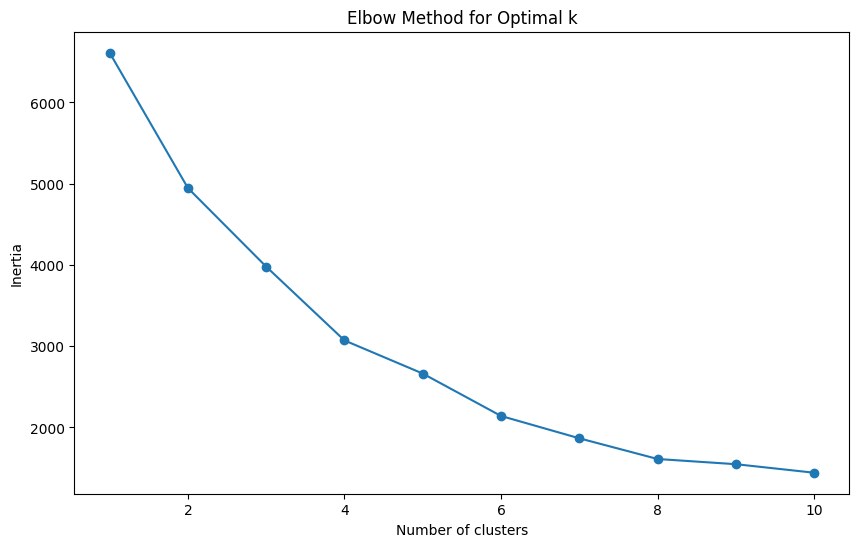

In [6]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(result_df[["recency_score", "frequency_score", "monetary_score"]])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [7]:
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
result_df['cluster'] = kmeans.fit_predict(result_df[["recency_score", "frequency_score", "monetary_score"]])

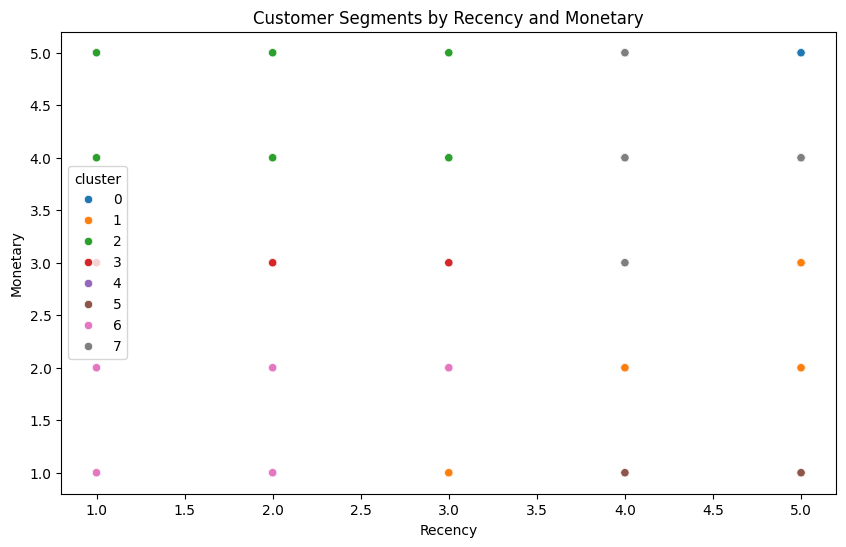

        recency_score           frequency_score           monetary_score           visitorId
                 mean       std            mean       std           mean       std     count
cluster                                                                                     
0                 4.5  0.559581            1.51  0.502418           4.06   0.83871       100
1            4.118881  0.800436        4.622378  0.486496       1.685315  0.675732       143
2            1.748344   0.69492        1.940397  0.801929       4.523179  0.501125       151
3            2.018405  0.804865        1.472393  0.500776       2.153374  0.820891       163
4            2.058824  0.823405        4.529412  0.500979       4.051471  0.782398       136
5             4.39604  0.584452        1.970297  0.793164       1.455446  0.500495       101
6            1.649635  0.723464        3.722628  0.773931       1.686131  0.683329       137
7            4.229412  0.713575        3.711765  0.764897       4.0647

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = result_df, x='recency_score', y='monetary_score', hue='cluster', palette='tab10')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Customer Segments by Recency and Monetary')
plt.show()

# Aggregate cluster information
cluster_summary = result_df.groupby('cluster').agg({
    'recency_score': ['mean', 'std'],
    'frequency_score': ['mean', 'std'],
    'monetary_score': ['mean', 'std'],
    'visitorId': 'count'
})

print(cluster_summary)

# Q2


How can we improve customer retention and lifetime value?

- Calculate customer churn rates and identify at-risk customers.
- <strong>Analyze the effectiveness of current retention strategies. (Not done)</strong>


## Google Analytics


In [3]:
query = f"""
        SELECT
            fullVisitorID,
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS CustomerPurchaseCount,
            trafficSource.source AS TrafficSource,
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160901' AND '20160930' AND
            hits.eCommerceAction.action_type = '6'
        GROUP BY fullVisitorID, Channel, TrafficSource
        ORDER BY CustomerPurchaseCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

/Users/brandonwoo/Desktop/GenAI/GenAI.backend/GenAI.Backend/.conda/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         fullVisitorID         Channel  TotalRevenue  CustomerPurchaseCount TrafficSource
0  8851822767477687842        Referral   30878760000                     96      (direct)
1   666582393118140484        Referral   20600080000                     68      (direct)
2  3033366073043100694        Referral   11512000000                     60      (direct)
3  5689475961693395998        Referral   15128780000                     54      (direct)
4  9377429831454005466  Organic Search   20728520000                     52        google
5  8436426603099391262        Referral   37197920000                     52      (direct)
6  5632276788326171571          Direct  673375500000                     42      (direct)
7  4923243433046835289          Direct   14585600000                     40      (direct)
8  5912152563864160997        Referral    9040400000                     40      (direct)
9  6374969976921419865          Direct    7172800000                     40      (direct) 



The most popular channel that is used by customers with a high purchase count


In [81]:
# https://medium.com/octave-john-keells-group/a-simple-six-step-approach-to-define-customer-churn-in-retail-f401e31e57c0#:~:text=Identifying%20the%20point%20in%20which,time%20to%20proactively%20implement%20interventions.&text=Step%206%3A,is%20identified%20as%20a%20churner.
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Select only the latest date for each visitor and check for their churn status
        RankedDates AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                LowerBoundOneMonthLag,
                ROW_NUMBER() OVER (
                    PARTITION BY fullVisitorID
                    ORDER BY Date DESC
                ) AS rn
            FROM LaggingThreshold
        )

        SELECT Date, fullVisitorID, DailyPurchaseCount, OneMonthMA, LowerBound, LowerBoundOneMonthLag
        FROM RankedDates
        ORDER BY Date
        """

rows = client.query(query)

result_df = rows.to_dataframe()

grouped_sum = result_df.groupby('fullVisitorID')[
    'DailyPurchaseCount'].sum().reset_index()

grouped_sum = grouped_sum.rename(
    columns={'DailyPurchaseCount': 'HistoricPurchases'})

df = result_df.merge(grouped_sum, on='fullVisitorID',
                     how='left').query("HistoricPurchases > 0")

df['Date'] = pd.to_datetime(df['Date'])

latest_idx = df.groupby('fullVisitorID')['Date'].idxmax()

result_df = df.loc[latest_idx].sort_values(by="Date")

print(result_df, "\n")

             Date        fullVisitorID  DailyPurchaseCount  OneMonthMA  LowerBound  LowerBoundOneMonthLag  HistoricPurchases
408    2016-08-01  5760753352577829144                  79    2.633333    2.633333                    0.0                 79
717    2016-08-01  6569605994631186947                  36    1.200000    1.200000                    0.0                 36
80     2016-08-01  2125540555068339394                  25    0.833333    0.833333                    0.0                 25
432    2016-08-01  7589137567725941774                  51    1.700000    1.700000                    0.0                 51
756    2016-08-01  5563168194966233133                  21    0.700000    0.700000                    0.0                 21
...           ...                  ...                 ...         ...         ...                    ...                ...
834084 2017-08-01   024507252193437459                  16    0.533333    0.406213                    0.0                 16


/var/folders/lj/tfjxb4wd4kx1kwshmxnt57840000gn/T/ipykernel_33309/253609387.py:103: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  how='left').query("HistoricPurchases > 0")


In [82]:
# Those that have not made a purchase within the last 3 months or have a monthly moving average less than the lower bound have a retention risk
max_date = result_df['Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
RetentionRiskCount = len(set(result_df.query(
    "Date <= @three_months_ago | LowerBoundOneMonthLag >= OneMonthMA").fullVisitorID))

# Those that have made a purchase within the last 3 months or have a monthly moving average more than the lower bound do not have a retention risk
RetentionCount = len(set(result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA").fullVisitorID))


result_df.query(
    "@three_months_ago <= Date <= @max_date & LowerBoundOneMonthLag < OneMonthMA")

,Date,fullVisitorID,DailyPurchaseCount,OneMonthMA,LowerBound,LowerBoundOneMonthLag,HistoricPurchases
650611,2017-05-01,536428604379922267,22,0.733333,0.733333,0.0,22
651870,2017-05-01,1749853719127085935,13,0.433333,0.433333,0.0,13
650822,2017-05-01,9740050408987139130,19,0.633333,0.633333,0.0,19
650153,2017-05-01,9565722193439879038,11,0.366667,0.279271,0.0,11
650942,2017-05-01,4501448098783068461,22,2.466667,1.636650,0.0,74
...,...,...,...,...,...,...,...
834084,2017-08-01,024507252193437459,16,0.533333,0.406213,0.0,16
835321,2017-08-01,5199370466032130686,0,0.866667,0.428464,0.0,26
834618,2017-08-01,3614707430894059857,28,0.933333,0.933333,0.0,28
833186,2017-08-01,9591202457292182670,20,0.666667,0.157052,0.0,20


These are the at risk customers as the lagged lower bound is greater or equal to their one month moving average on purchase count


In [9]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those with a retention risk: Less than threshold or have not purchased within the last 3 months
        RetentionRisk AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag >= lt.OneMonthMA AND lt.Date < (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                RetentionRisk
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            RetentionRisk,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          4419         43.154297
1  Organic Search          2360         23.046875
2         Display          1668         16.289062
3          Direct          1455         14.208984
4     Paid Search           239          2.333984
5          Social            96          0.937500
6      Affiliates             3          0.029297
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [8]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) - 1) / 89, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those without a retention risk: More than threshold or have purchased within the last 3 months
        Retention AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag < lt.OneMonthMA AND lt.Date >= (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                Retention
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            Retention,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel  Transactions  Transactions_Pct
0        Referral          3695         39.812520
1          Direct          2193         23.628919
2  Organic Search          2133         22.982437
3         Display           884          9.524836
4     Paid Search           307          3.307833
5          Social            63          0.678806
6      Affiliates             6          0.064648
7         (Other)             0          0.000000 



Overview of channels used by those who do not have a retention risk


In [83]:
ChurnRate = (RetentionRiskCount /
             (RetentionRiskCount + RetentionCount)) * 100

print("The churn rate for google online store is :", ChurnRate, "% \n")

The churn rate for google online store is : 69.27042030134814 % 



# Q3


What are the most effective marketing channels and campaigns? - Evaluate the ROI of different marketing channels.

- Analyze the impact of various promotional campaigns on sales.


## Google Analytics


In [12]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            trafficSource.source AS TrafficSource,
            CASE
                WHEN hits.eCommerceAction.action_type = '1' THEN 'Click product lists'
                WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
                WHEN hits.eCommerceAction.action_type = '3' THEN 'Add to cart'
                WHEN hits.eCommerceAction.action_type = '4' THEN 'Remove from cart'
                WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                WHEN hits.eCommerceAction.action_type = '6' THEN 'Purchase'
                WHEN hits.eCommerceAction.action_type = '7' THEN 'Refund'
                WHEN hits.eCommerceAction.action_type = '0' THEN 'Unknown'
            END AS Action,
            COUNT(fullVisitorID) AS UserCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type != '0'
        GROUP BY Action, TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 10
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

          Channel TrafficSource                Action  UserCount
0  Organic Search        google   Click product lists     130574
1  Organic Search        google  View product details     105817
2        Referral      (direct)   Click product lists      95294
3        Referral      (direct)             Check out      95200
4  Organic Search      (direct)   Click product lists      80034
5          Direct      (direct)   Click product lists      78922
6        Referral      (direct)  View product details      77032
7  Organic Search      (direct)  View product details      65341
8          Direct      (direct)  View product details      63953
9  Organic Search        google             Check out      54376 



Using the dataframe above, we can find which platform and method is the most effective in influencing sales


In [13]:
query = f"""
        SELECT
            channelGrouping AS Channel,
            SUM(totals.totalTransactionRevenue) AS TotalRevenue,
            COUNT(fullVisitorID) AS UserCount,
            SUM(totals.totalTransactionRevenue) / COUNT(fullVisitorID) AS AVGRevenuePerUser,
            trafficSource.source AS TrafficSource,
            CASE
                WHEN hits.eCommerceAction.action_type = '1' THEN 'Click product lists'
                WHEN hits.eCommerceAction.action_type = '2' THEN 'View product details'
                WHEN hits.eCommerceAction.action_type = '3' THEN 'Add to cart'
                WHEN hits.eCommerceAction.action_type = '4' THEN 'Remove from cart'
                WHEN hits.eCommerceAction.action_type = '5' THEN 'Check out'
                WHEN hits.eCommerceAction.action_type = '6' THEN 'Purchase'
                WHEN hits.eCommerceAction.action_type = '7' THEN 'Refund'
                WHEN hits.eCommerceAction.action_type = '0' THEN 'Unknown'
            END AS Action
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits,
            UNNEST(hits.product) AS product
        WHERE
            hits.eCommerceAction.action_type = '6'
        GROUP BY Action, TrafficSource, Channel
        ORDER BY UserCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           Channel   TotalRevenue  UserCount  AVGRevenuePerUser            TrafficSource    Action
0         Referral  6861093620000      32354       2.120632e+08                 (direct)  Purchase
1           Direct  9231074220000      14684       6.286485e+08                 (direct)  Purchase
2   Organic Search  3403071550000      13419       2.536010e+08                   google  Purchase
3   Organic Search  1709765760000       7592       2.252062e+08                 (direct)  Purchase
4      Paid Search   361601340000       1628       2.221138e+08                   google  Purchase
5      Paid Search   207373340000       1296       1.600103e+08                 (direct)  Purchase
6          Display  4605551900000       1010       4.559952e+09                      dfa  Purchase
7         Referral   374165040000        578       6.473444e+08          mail.google.com  Purchase
8         Referral    84159360000        356       2.364027e+08            dealspotr.com  Purchase
9         

Referral searches is currently the most popular method when purchasing an item

Direct searches generates a greater revenue


In [144]:
# For each page title, find the number of customers and the way people are able to search for their products -> Which is the most effective
query = f"""
        SELECT
            IF(LENGTH(hits.page.pageTitle) <= 20, hits.page.pageTitle, CONCAT(SUBSTR(hits.page.pageTitle, 1, 20), '...')) AS PageTitle,
            channelGrouping AS Channel,
            COUNT(fullVisitorID) AS VisitorCount,
            SUM(IF(totals.transactions IS NULL, 0, totals.transactions)) AS TransactionCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.page.pageTitle NOT LIKE '%Checkout%'
            AND hits.page.pageTitle NOT LIKE '%Home%'
            AND hits.page.pageTitle NOT LIKE '%Cart%'
            AND hits.page.pageTitle NOT LIKE '%Google%'
            AND hits.page.pageTitle NOT LIKE '%Payment%'
            AND hits.page.pageTitle NOT LIKE '%results%'
        GROUP BY PageTitle, Channel
        ORDER BY VisitorCount DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

print(result_df, "\n")

           PageTitle         Channel  VisitorCount  TransactionCount
0     Men's-T-Shirts  Organic Search         31922              2698
1             Office  Organic Search         22441              2107
2   Page Unavailable        Referral         21349               499
3               Bags  Organic Search         19002              1288
4        Electronics  Organic Search         18657              2486
5          Drinkware  Organic Search         17328              1861
6     Men's-T-Shirts        Referral         14478              3573
7            Apparel  Organic Search         12960               899
8          Lifestyle  Organic Search         12844              1428
9               Bags        Referral         11839              1474
10            Office        Referral         11747              2691
11           YouTube  Organic Search         11369               472
12       Electronics        Referral         11298              1629
13         Drinkware        Referr

Referral and organic searches are clearly the most popular traffic channels and a higher traffic generally equates to a higher transaction count
